# Threshold Tuning + Ensemble: Top 3 Models

Objective:
Maximize the binary F1 score (pos_label=1) by adjusting the decision threshold and combining the best models into an ensemble.

Models:
- **Model 1:** DeBERTa + ALIGN + Caption BLIP2 + proj_concat (F1: 86.05%*)
- **Model 2:** DeBERTa + ALIGN + Caption BLIP2 + mean (F1: 85.04%*)
- **Model 3:** DeBERTa + BLIP + Caption BLIP2 + mean (F1: ~84.8%*)

Idea:
1. Retrain and save the 3 models
2. Individual threshold tuning (sweep 0.30 → 0.70)
3. Ensemble (soft vote + weighted) with threshold tuning

*Scores Achieved in Caption Generation Notebook.

In [1]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
from transformers import AutoTokenizer, AutoModel,BlipProcessor, BlipModel,AlignProcessor, AlignModel,get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA available: True
Device: NVIDIA H100 NVL


In [2]:
# Paths
DATA_PATH   = "../../../data/"
IMG_PATH    = "../../../data/images"
OUTPUT_DIR  = "../../../results/multimodal/threshold_ensemble/"
MODELS_DIR  = os.path.join(OUTPUT_DIR, "saved_models/")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [3]:
# Model names
TEXT_MODEL_NAME  = "microsoft/deberta-v3-base"
BLIP_MODEL_NAME  = "Salesforce/blip-itm-base-coco"
ALIGN_MODEL_NAME = "kakaobrain/align-base"

# Training config (same as previous experiments for comparability)
MAX_TEXT_LENGTH = 128
COMMON_DIM      = 768
NUM_CLASSES     = 2
BATCH_SIZE      = 16
NUM_EPOCHS      = 15
LEARNING_RATE   = 2e-5
WEIGHT_DECAY    = 1e-4
WARMUP_RATIO    = 0.1
PATIENCE        = 5

# Threshold sweep config
THRESHOLD_MIN   = 0.30
THRESHOLD_MAX   = 0.70
THRESHOLD_STEP  = 0.01

print("Configuration loaded.")

Configuration loaded.


In [4]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "train_with_captions.csv"))
df_dev   = pd.read_csv(os.path.join(DATA_PATH, "dev_with_captions.csv"))
df_test  = pd.read_csv(os.path.join(DATA_PATH, "test_with_captions.csv"))

# Map labels
stance_2id = {"oppose": 0, "support": 1}
for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)

print(f"Train: {len(df_train)} | Dev: {len(df_dev)} | Test: {len(df_test)}")
print(f"\nTrain Stance:\n{df_train['stance'].value_counts()}")
print(f"\nDev Stance:\n{df_dev['stance'].value_counts()}")
print(f"\nTest Stance:\n{df_test['stance'].value_counts()}")

Train: 2190 | Dev: 200 | Test: 300

Train Stance:
stance
support    1095
oppose     1095
Name: count, dtype: int64

Dev Stance:
stance
oppose     127
support     73
Name: count, dtype: int64

Test Stance:
stance
oppose     182
support    118
Name: count, dtype: int64


In [5]:
class MultimodalCaptionDataset(Dataset):
    """
    Dataset for Text + Caption + Image.
    text_input = tweet_text + [SEP] + caption
    """
    def __init__(self, df, img_dir, tokenizer, image_processor, caption_column, max_length=128):
        self.df= df.reset_index(drop=True)
        self.img_dir= img_dir
        self.tokenizer= tokenizer
        self.image_processor= image_processor
        self.caption_column= caption_column
        self.max_length= max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Text + Caption concatenation
        text    = str(row['tweet_text'])
        caption = str(row[self.caption_column])
        combined = f"{text} [SEP] {caption}"

        text_enc = self.tokenizer(
            combined,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Image
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))

        img_enc = self.image_processor(images=image, return_tensors='pt')

        return {
            'input_ids':      text_enc['input_ids'].squeeze(0),
            'attention_mask': text_enc['attention_mask'].squeeze(0),
            'pixel_values':   img_enc['pixel_values'].squeeze(0),
            'label':          torch.tensor(row['label'], dtype=torch.long)
        }


def collate_fn(batch):
    return {
        'input_ids':      torch.stack([b['input_ids']      for b in batch]),
        'attention_mask': torch.stack([b['attention_mask'] for b in batch]),
        'pixel_values':   torch.stack([b['pixel_values']   for b in batch]),
        'labels':         torch.stack([b['label']          for b in batch])
    }

In [6]:
class MultimodalModel(nn.Module):
    """
    DeBERTa (text+caption) + Vision encoder (BLIP or ALIGN).
    Supports: concat, mean, weighted_mean, proj_concat, gated.
    """
    def __init__(
        self,
        text_model_name  = "microsoft/deberta-v3-base",
        vision_model_name= "Salesforce/blip-itm-base-coco",
        vision_type      = "blip",
        num_classes      = 2,
        fusion_type      = "proj_concat",
        common_dim       = 768,
        dropout          = 0.1):

        super().__init__()
        self.fusion_type = fusion_type
        self.common_dim  = common_dim

        # Text encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim     = self.text_encoder.config.hidden_size

        # Vision encoder
        if vision_type == "blip":
            blip_full= BlipModel.from_pretrained(vision_model_name)
            self.vision_encoder= blip_full.vision_model
            self.vision_dim= blip_full.config.vision_config.hidden_size
        else:  # align
            align_full= AlignModel.from_pretrained(vision_model_name)
            self.vision_encoder= align_full.vision_model
            self.vision_dim = align_full.config.vision_config.hidden_dim 

        # Projections to common_dim
        self.text_projection= nn.Linear(self.text_dim, common_dim)   if self.text_dim   != common_dim else nn.Identity()
        self.vision_projection= nn.Linear(self.vision_dim, common_dim) if self.vision_dim != common_dim else nn.Identity()

        # Fusion-specific layers
        if fusion_type == "concat":
            self.fusion_layer = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim), nn.ReLU(), nn.Dropout(dropout))

        elif fusion_type == "mean":
            self.fusion_layer = nn.Identity()

        elif fusion_type == "weighted_mean":
            self.text_weight   = nn.Parameter(torch.tensor(0.5))
            self.vision_weight = nn.Parameter(torch.tensor(0.5))
            self.fusion_layer  = nn.Identity()

        elif fusion_type == "proj_concat":
            proj_dim = common_dim // 2
            self.text_proj   = nn.Linear(common_dim, proj_dim)
            self.vision_proj = nn.Linear(common_dim, proj_dim)
            self.fusion_layer = nn.Sequential(
                nn.Linear(proj_dim * 2, common_dim), nn.ReLU(), nn.Dropout(dropout))

        elif fusion_type == "gated":
            self.gate = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim), nn.Sigmoid())
            self.fusion_layer = nn.Identity()

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(common_dim // 2, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_projection(text_out.last_hidden_state[:, 0, :])

        # Vision
        vis_out    = self.vision_encoder(pixel_values=pixel_values)
        vision_emb = self.vision_projection(vis_out.pooler_output)

        # Fusion
        if self.fusion_type == "concat":
            fused = self.fusion_layer(torch.cat([text_emb, vision_emb], dim=1))

        elif self.fusion_type == "mean":
            fused = (text_emb + vision_emb) / 2

        elif self.fusion_type == "weighted_mean":
            w_t = torch.sigmoid(self.text_weight)
            w_v = torch.sigmoid(self.vision_weight)
            fused = (w_t * text_emb + w_v * vision_emb) / (w_t + w_v)

        elif self.fusion_type == "proj_concat":
            fused = self.fusion_layer(
                torch.cat([self.text_proj(text_emb), self.vision_proj(vision_emb)], dim=1))

        elif self.fusion_type == "gated":
            gate  = self.gate(torch.cat([text_emb, vision_emb], dim=1))
            fused = gate * text_emb + (1 - gate) * vision_emb

        return self.classifier(fused)

In [7]:
def train_model(model, train_loader, dev_loader, save_path, device=DEVICE):
    """
    Train model with early stopping. Saves best checkpoint to save_path.
    Returns trained model and best dev F1.
    """
    model= model.to(device)
    optimizer= torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    total_steps= len(train_loader) * NUM_EPOCHS
    warmup_steps= int(total_steps * WARMUP_RATIO)
    scheduler= get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    criterion= nn.CrossEntropyLoss()

    best_f1= 0.0
    patience_counter= 0
    best_model_state= None

    for epoch in range(NUM_EPOCHS):
        # --- Train ---
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"  Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values   = batch['pixel_values'].to(device)
            labels         = batch['labels'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, pixel_values)
            loss   = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        # --- Validate ---
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in dev_loader:
                logits = model(
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['pixel_values'].to(device)
                )
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].numpy())

        _, _, dev_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='binary', pos_label=1, zero_division=0)

        avg_loss = train_loss / len(train_loader)
        print(f"  Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Dev F1: {dev_f1:.4f}", end="")

        if dev_f1 > best_f1:
            best_f1          = dev_f1
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, save_path)
            print("(Best)")
        else:
            patience_counter += 1
            print(f" (patience {patience_counter}/{PATIENCE})")
            if patience_counter >= PATIENCE:
                print(f"  Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    print(f"  Training done. Best Dev F1: {best_f1:.4f}")
    return model, best_f1

### Inference Function (To get Probabilities)

In [8]:
def get_probabilities(model, loader, device=DEVICE):
    """
    Returns softmax probabilities and true labels for a dataloader.
    Shape: probs (N, num_classes), labels (N,)
    """
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['pixel_values'].to(device)
            )
            probs = F.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(batch['labels'].numpy())

    return np.array(all_probs), np.array(all_labels)


def apply_threshold(probs, threshold=0.5):
    """
    Apply custom threshold on P(support) to generate predictions.
    Predicts Support (1) if P(support) >= threshold, else Oppose (0).
    """
    return (probs[:, 1] >= threshold).astype(int)


def compute_metrics(labels, preds):
    """
    Compute accuracy, F1-binary, precision, recall.
    """
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1, zero_division=0)
    return {
        'accuracy':  accuracy,
        'f1_binary': f1,
        'precision': precision,
        'recall':    recall
    }

## Threshold Tuning Function

In [9]:
def find_best_threshold(probs, labels):
    """
    Sweep thresholds on dev set. Returns best threshold and its F1.
    """
    thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
    best_threshold = 0.5
    best_f1        = 0.0
    sweep_results  = []

    for t in thresholds:
        preds = apply_threshold(probs, threshold=t)
        _, _, f1, _ = precision_recall_fscore_support(
            labels, preds, average='binary', pos_label=1, zero_division=0)
        sweep_results.append({'threshold': round(t, 2), 'f1': f1})

        if f1 > best_f1:
            best_f1        = f1
            best_threshold = round(t, 2)

    return best_threshold, best_f1, pd.DataFrame(sweep_results)


def evaluate_with_threshold(probs_dev, labels_dev, probs_test, labels_test, model_name):
    """
    Full evaluation:
    1. Default threshold (0.5) on test
    2. Find best threshold on dev
    3. Apply best threshold on test
    Returns two result dicts and the sweep DataFrame.
    """

    # Default threshold on test
    preds_default = apply_threshold(probs_test, threshold=0.5)
    metrics_default = compute_metrics(labels_test, preds_default)

    # Find best threshold on dev
    best_t, best_dev_f1, sweep_df = find_best_threshold(probs_dev, labels_dev)

    # Apply best threshold on test
    preds_tuned = apply_threshold(probs_test, threshold=best_t)
    metrics_tuned = compute_metrics(labels_test, preds_tuned)

    print(f"  Default (t=0.50) → Test F1: {metrics_default['f1_binary']:.4f}")
    print(f"  Best Dev threshold: {best_t} (Dev F1: {best_dev_f1:.4f})")
    print(f"  Tuned   (t={best_t}) to Test F1: {metrics_tuned['f1_binary']:.4f}  "
          f"[diff {metrics_tuned['f1_binary']-metrics_default['f1_binary']:+.4f}]")

    result_default = {
        'Model':     model_name,
        'Threshold': 0.50,
        'Tuned':     False,
        'Dev_F1':    compute_metrics(labels_dev, apply_threshold(probs_dev, 0.5))['f1_binary'],
        'Test_F1':        metrics_default['f1_binary'],
        'Test_Accuracy':  metrics_default['accuracy'],
        'Test_Precision': metrics_default['precision'],
        'Test_Recall':    metrics_default['recall']
    }
    result_tuned = {
        'Model':     model_name,
        'Threshold': best_t,
        'Tuned':     True,
        'Dev_F1':    best_dev_f1,
        'Test_F1':        metrics_tuned['f1_binary'],
        'Test_Accuracy':  metrics_tuned['accuracy'],
        'Test_Precision': metrics_tuned['precision'],
        'Test_Recall':    metrics_tuned['recall']
    }

    return result_default, result_tuned, sweep_df

### Initialize Tokenizers and Processors

In [10]:
tokenizer       = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
blip_processor  = BlipProcessor.from_pretrained(BLIP_MODEL_NAME)
align_processor = AlignProcessor.from_pretrained(ALIGN_MODEL_NAME)
print("Tokenizers and processors loaded")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Tokenizers and processors loaded


### We dfine the 3 Top Model Configurations

In [11]:
MODEL_CONFIGS = [
    {
        'name':            'DeBERTa+ALIGN+BLIP2cap+proj_concat',
        'description':     'DeBERTa + ALIGN',
        'comments':        'Caption BLIP2 + Fusion: proj_concat',
        'vision_model':    ALIGN_MODEL_NAME,
        'vision_type':     'align',
        'vision_proc':     align_processor,
        'caption_col':     'caption_blip2',
        'fusion_type':     'proj_concat',
        'save_path':       os.path.join(MODELS_DIR, 'model1_align_blip2cap_projconcat.pt')
    },
    {
        'name':            'DeBERTa+ALIGN+BLIP2cap+mean',
        'description':     'DeBERTa + ALIGN',
        'comments':        'Caption BLIP2 + Fusion: mean',
        'vision_model':    ALIGN_MODEL_NAME,
        'vision_type':     'align',
        'vision_proc':     align_processor,
        'caption_col':     'caption_blip2',
        'fusion_type':     'mean',
        'save_path':       os.path.join(MODELS_DIR, 'model2_align_blip2cap_mean.pt')
    },
    {
        'name':            'DeBERTa+BLIP+BLIP2cap+mean',
        'description':     'DeBERTa + BLIP',
        'comments':        'Caption BLIP2 + Fusion: mean',
        'vision_model':    BLIP_MODEL_NAME,
        'vision_type':     'blip',
        'vision_proc':     blip_processor,
        'caption_col':     'caption_blip2',
        'fusion_type':     'mean',
        'save_path':       os.path.join(MODELS_DIR, 'model3_blip_blip2cap_mean.pt')
    }
]

print(f"\n{len(MODEL_CONFIGS)} models to train and evaluate:")
for i, cfg in enumerate(MODEL_CONFIGS, 1):
    print(f"  {i}. {cfg['name']}")


3 models to train and evaluate:
  1. DeBERTa+ALIGN+BLIP2cap+proj_concat
  2. DeBERTa+ALIGN+BLIP2cap+mean
  3. DeBERTa+BLIP+BLIP2cap+mean


## 1. Train, Save, and Threshold Tune Each Model


MODEL: DeBERTa+ALIGN+BLIP2cap+proj_concat


  Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 01 | Loss: 0.6636 | Dev F1: 0.6355 ✓ Best


  Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 02 | Loss: 0.3115 | Dev F1: 0.8667 ✓ Best


  Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 03 | Loss: 0.1822 | Dev F1: 0.8919 ✓ Best


  Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 04 | Loss: 0.1275 | Dev F1: 0.8571 (patience 1/5)


  Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 05 | Loss: 0.0699 | Dev F1: 0.8382 (patience 2/5)


  Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 06 | Loss: 0.0298 | Dev F1: 0.8844 (patience 3/5)


  Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 07 | Loss: 0.0192 | Dev F1: 0.8551 (patience 4/5)


  Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 08 | Loss: 0.0125 | Dev F1: 0.8828 (patience 5/5)
  Early stopping triggered.
  Training done. Best Dev F1: 0.8919
  Computing probabilities...
  Threshold tuning...
  Default (t=0.50) → Test F1: 0.8370
  Best Dev threshold: 0.3 (Dev F1: 0.8919)
  Tuned   (t=0.3) → Test F1: 0.8278  [diff -0.0092]


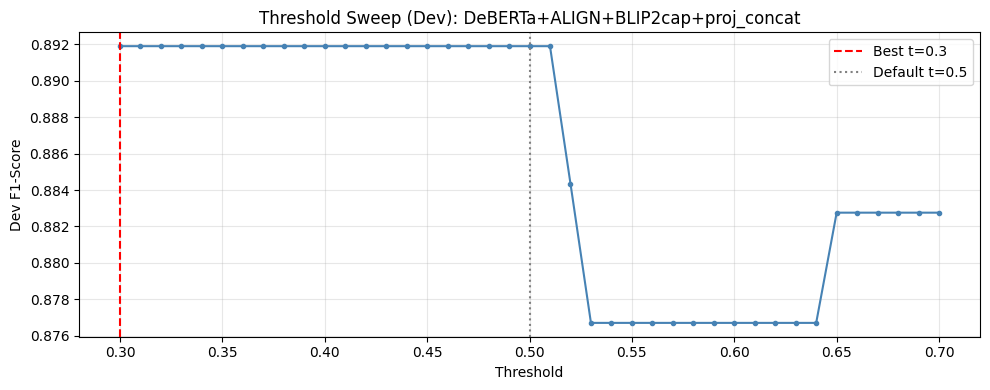


MODEL: DeBERTa+ALIGN+BLIP2cap+mean


  Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 01 | Loss: 0.6414 | Dev F1: 0.7500 ✓ Best


  Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 02 | Loss: 0.3015 | Dev F1: 0.8777 ✓ Best


  Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 03 | Loss: 0.2060 | Dev F1: 0.8485 (patience 1/5)


  Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 04 | Loss: 0.1226 | Dev F1: 0.8824 ✓ Best


  Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 05 | Loss: 0.0690 | Dev F1: 0.8657 (patience 1/5)


  Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 06 | Loss: 0.0280 | Dev F1: 0.8794 (patience 2/5)


  Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 07 | Loss: 0.0181 | Dev F1: 0.8714 (patience 3/5)


  Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 08 | Loss: 0.0090 | Dev F1: 0.8657 (patience 4/5)


  Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 09 | Loss: 0.0073 | Dev F1: 0.8904 ✓ Best


  Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 10 | Loss: 0.0047 | Dev F1: 0.8794 (patience 1/5)


  Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 11 | Loss: 0.0034 | Dev F1: 0.8904 (patience 2/5)


  Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 12 | Loss: 0.0070 | Dev F1: 0.8936 ✓ Best


  Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 13 | Loss: 0.0017 | Dev F1: 0.8811 (patience 1/5)


  Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 14 | Loss: 0.0015 | Dev F1: 0.8873 (patience 2/5)


  Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 15 | Loss: 0.0032 | Dev F1: 0.8921 (patience 3/5)
  Training done. Best Dev F1: 0.8936
  Computing probabilities...
  Threshold tuning...
  Default (t=0.50) → Test F1: 0.8365
  Best Dev threshold: 0.41 (Dev F1: 0.8936)
  Tuned   (t=0.41) → Test F1: 0.8365  [diff +0.0000]


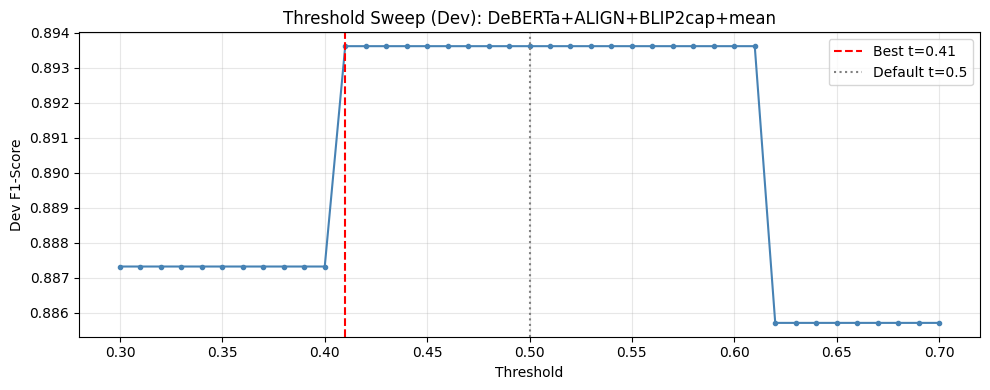


MODEL: DeBERTa+BLIP+BLIP2cap+mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 01 | Loss: 0.5903 | Dev F1: 0.4040 ✓ Best


  Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 02 | Loss: 0.2896 | Dev F1: 0.7627 ✓ Best


  Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 03 | Loss: 0.1346 | Dev F1: 0.8816 ✓ Best


  Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 04 | Loss: 0.0602 | Dev F1: 0.8741 (patience 1/5)


  Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 05 | Loss: 0.0187 | Dev F1: 0.8841 ✓ Best


  Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 06 | Loss: 0.0112 | Dev F1: 0.8873 ✓ Best


  Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 07 | Loss: 0.0057 | Dev F1: 0.8777 (patience 1/5)


  Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 08 | Loss: 0.0036 | Dev F1: 0.8777 (patience 2/5)


  Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 09 | Loss: 0.0067 | Dev F1: 0.8841 (patience 3/5)


  Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 10 | Loss: 0.0025 | Dev F1: 0.8905 ✓ Best


  Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 11 | Loss: 0.0020 | Dev F1: 0.8955 ✓ Best


  Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 12 | Loss: 0.0022 | Dev F1: 0.8702 (patience 1/5)


  Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 13 | Loss: 0.0008 | Dev F1: 0.8806 (patience 2/5)


  Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 14 | Loss: 0.0013 | Dev F1: 0.8889 (patience 3/5)


  Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

  Epoch 15 | Loss: 0.0009 | Dev F1: 0.8889 (patience 4/5)
  Training done. Best Dev F1: 0.8955
  Computing probabilities...
  Threshold tuning...
  Default (t=0.50) → Test F1: 0.8434
  Best Dev threshold: 0.49 (Dev F1: 0.8955)
  Tuned   (t=0.49) → Test F1: 0.8480  [diff +0.0046]


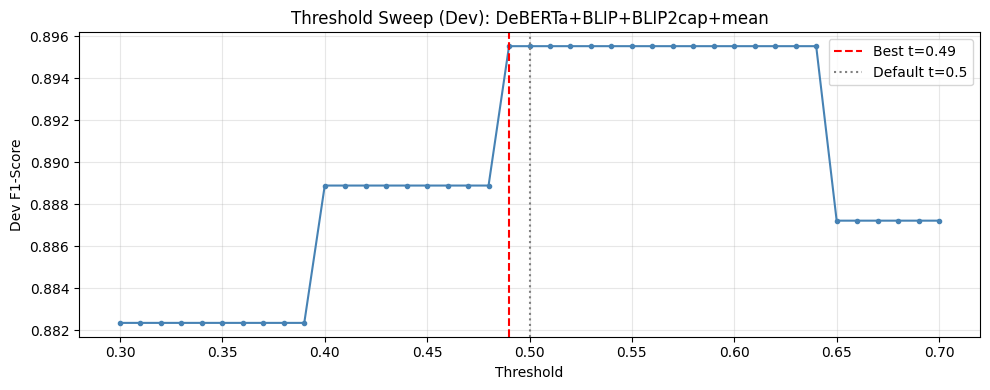

All 3 models trained and threshold-tuned


In [12]:
all_results  = []
model_probs  = []   

for cfg in MODEL_CONFIGS:
    print("\n" + "="*70)
    print(f"MODEL: {cfg['name']}")
    print("="*70)

    # Create datasets and dataloaders
    train_ds = MultimodalCaptionDataset(df_train, IMG_PATH, tokenizer, cfg['vision_proc'], cfg['caption_col'], MAX_TEXT_LENGTH)
    dev_ds   = MultimodalCaptionDataset(df_dev,   IMG_PATH, tokenizer, cfg['vision_proc'], cfg['caption_col'], MAX_TEXT_LENGTH)
    test_ds  = MultimodalCaptionDataset(df_test,  IMG_PATH, tokenizer, cfg['vision_proc'], cfg['caption_col'], MAX_TEXT_LENGTH)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # We train 
    model = MultimodalModel(
        text_model_name   = TEXT_MODEL_NAME,
        vision_model_name = cfg['vision_model'],
        vision_type       = cfg['vision_type'],
        num_classes       = NUM_CLASSES,
        fusion_type       = cfg['fusion_type'],
        common_dim        = COMMON_DIM
    )
    trained_model, best_dev_f1 = train_model(model, train_loader, dev_loader, cfg['save_path'])

    # We get probabilities for dev and test
    print("  Computing probabilities...")
    probs_dev,  labels_dev  = get_probabilities(trained_model, dev_loader)
    probs_test, labels_test = get_probabilities(trained_model, test_loader)

    # Store for ensemble
    model_probs.append({
        'name':        cfg['name'],
        'probs_dev':   probs_dev,
        'probs_test':  probs_test,
        'labels_dev':  labels_dev,
        'labels_test': labels_test,
        'best_dev_f1': best_dev_f1
    })

    # We start the threshold tuning and evaluation
    print("  Threshold tuning...")
    result_default, result_tuned, sweep_df = evaluate_with_threshold(probs_dev,
                                                                      labels_dev,
                                                                        probs_test,
                                                                          labels_test, cfg['name'])
    # Add description/comments for readability
    for r in [result_default, result_tuned]:
        r['Description'] =cfg['description']
        r['Comments']    =cfg['comments']

    all_results.extend([result_default, result_tuned])

    # Save threshold sweep plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sweep_df['threshold'], sweep_df['f1'], marker='o', markersize=3, color='steelblue')
    ax.axvline(result_tuned['Threshold'], color='red', linestyle='--', label=f"Best t={result_tuned['Threshold']}")
    ax.axvline(0.5, color='gray', linestyle=':', label='Default t=0.5')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Dev F1-Score')
    ax.set_title(f'Threshold Sweep (Dev): {cfg["name"]}')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"threshold_sweep_{cfg['name']}.png"), dpi=150)
    plt.show()

    # Cleanup GPU memory
    del model, trained_model, train_ds, dev_ds, test_ds
    torch.cuda.empty_cache()

print("All 3 models trained and threshold-tuned")

## 2. Ensemble

In [13]:
print("\n" + "="*70)
print("PHASE 2: ENSEMBLE")
print("="*70)

# Stack probabilities
probs_dev_stack  = np.stack([m['probs_dev']  for m in model_probs])
probs_test_stack = np.stack([m['probs_test'] for m in model_probs])  
labels_dev       = model_probs[0]['labels_dev']
labels_test      = model_probs[0]['labels_test']
dev_f1_scores    = np.array([m['best_dev_f1'] for m in model_probs])

print(f"\nModel weights (based on Dev F1):")
for m, f1 in zip(model_probs, dev_f1_scores):
    print(f"  {m['name']}: Dev F1 = {f1:.4f}")


PHASE 2: ENSEMBLE

Model weights (based on Dev F1):
  DeBERTa+ALIGN+BLIP2cap+proj_concat: Dev F1 = 0.8919
  DeBERTa+ALIGN+BLIP2cap+mean: Dev F1 = 0.8936
  DeBERTa+BLIP+BLIP2cap+mean: Dev F1 = 0.8955


In [15]:

# Ensemble 1: Soft Vote (Average probabilities across models)
print(" Averaging probabilities across models and tuning threshold...")
probs_dev_soft  = probs_dev_stack.mean(axis=0)   # (N_dev, 2)
probs_test_soft = probs_test_stack.mean(axis=0)  # (N_test, 2)

result_soft_default, result_soft_tuned, sweep_soft = evaluate_with_threshold(probs_dev_soft, 
                                                                             labels_dev,
                                                                             probs_test_soft, 
                                                                             labels_test,
                                                                             model_name='Ensemble_SoftVote')
for r in [result_soft_default, result_soft_tuned]:
    r['Description'] ='Ensemble'
    r['Comments']    ='Soft Vote (equal weights)'

all_results.extend([result_soft_default, result_soft_tuned])

 Averaging probabilities across models and tuning threshold...
  Default (t=0.50) → Test F1: 0.8473
  Best Dev threshold: 0.3 (Dev F1: 0.9128)
  Tuned   (t=0.3) → Test F1: 0.8401  [diff -0.0072]


In [16]:
# Ensemble 2: Weighted Vote (weights = Dev F1)
print(" Calculating weighted probabilities based on Dev F1 scores...")
weights = dev_f1_scores / dev_f1_scores.sum()  # We Normalize them
print(f"  Normalized weights: {[round(w, 3) for w in weights]}")

probs_dev_weighted  = (probs_dev_stack  * weights[:, None, None]).sum(axis=0)
probs_test_weighted = (probs_test_stack * weights[:, None, None]).sum(axis=0)

result_wt_default, result_wt_tuned, sweep_wt = evaluate_with_threshold(probs_dev_weighted, labels_dev,
                                                                       probs_test_weighted, labels_test,
                                                                       model_name='Ensemble_WeightedVote')

for r in [result_wt_default, result_wt_tuned]:
    r['Description'] = 'Ensemble'
    r['Comments']    = 'Weighted Vote (Dev F1 weights)'

all_results.extend([result_wt_default, result_wt_tuned])

 Calculating weighted probabilities based on Dev F1 scores...
  Normalized weights: [np.float64(0.333), np.float64(0.333), np.float64(0.334)]
  Default (t=0.50) → Test F1: 0.8473
  Best Dev threshold: 0.3 (Dev F1: 0.9128)
  Tuned   (t=0.3) → Test F1: 0.8401  [diff -0.0072]


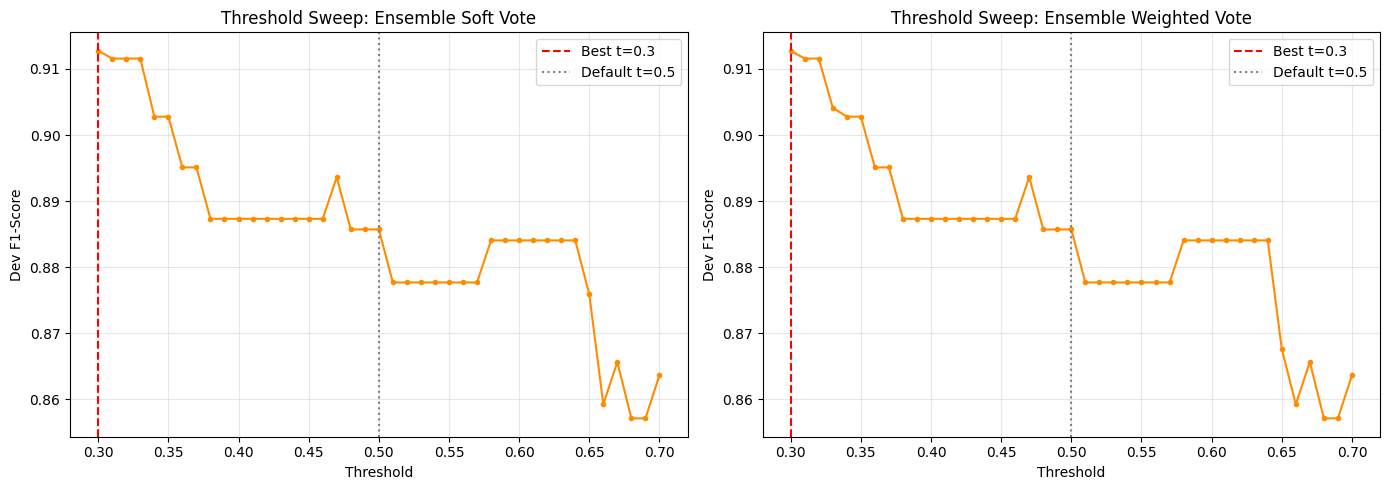

In [17]:
# Ensemble threshold sweep plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, sweep_df, title, best_t in [
    (axes[0], sweep_soft, 'Soft Vote', result_soft_tuned['Threshold']),
    (axes[1], sweep_wt,   'Weighted Vote', result_wt_tuned['Threshold'])
]:
    ax.plot(sweep_df['threshold'], sweep_df['f1'], marker='o', markersize=3, color='darkorange')
    ax.axvline(best_t, color='red',  linestyle='--', label=f'Best t={best_t}')
    ax.axvline(0.5,    color='gray', linestyle=':',  label='Default t=0.5')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Dev F1-Score')
    ax.set_title(f'Threshold Sweep: Ensemble {title}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'threshold_sweep_ensemble.png'), dpi=150)
plt.show()

#3. Final Results

In [18]:
# Build final DataFrame
df_results = pd.DataFrame(all_results)

# Reorder columns
df_results = df_results[[
    'Description', 'Comments', 'Tuned', 'Threshold',
    'Dev_F1', 'Test_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall'
]]

# Round
for col in ['Dev_F1', 'Test_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']:
    df_results[col] = df_results[col].round(4)

# Sort by Test_F1
df_results = df_results.sort_values('Test_F1', ascending=False).reset_index(drop=True)
df_results.head()

# Save
out_path = os.path.join(OUTPUT_DIR, 'results_threshold_ensemble.csv')
df_results.to_csv(out_path, index=False)
print(f"\nResults saved to: {out_path}")


Results saved to: ../../../results/multimodal/threshold_ensemble/results_threshold_ensemble.csv


## Best Model Summary

In [ ]:
best = df_results.iloc[0]

print("🏆 BEST OVERALL MODEL")
print(f"  Description:    {best['Description']}")
print(f"  Comments:       {best['Comments']}")
print(f"  Tuned:          {best['Tuned']} (threshold={best['Threshold']})")
print(f"  Test F1:        {best['Test_F1']:.4f}")
print(f"  Test Accuracy:  {best['Test_Accuracy']:.4f}")
print(f"  Test Precision: {best['Test_Precision']:.4f}")
print(f"  Test Recall:    {best['Test_Recall']:.4f}")
print(f"  Dev F1:         {best['Dev_F1']:.4f}")

🏆 BEST OVERALL MODEL
  Description:    DeBERTa + BLIP
  Comments:       Caption BLIP2 + Fusion: mean
  Tuned:          True (threshold=0.49)
  Test F1:        0.8480
  Test Accuracy:  0.8733
  Test Precision: 0.8030
  Test Recall:    0.8983
  Dev F1:         0.8955


GAIN FROM THRESHOLD TUNING (default 0.5 to tuned)


TypeError: unsupported format string passed to Series.__format__